## Linear Regression
### Name: Dallin Stewart
### Class: ACME
### Section: 002
### Date: The problem with being clever, ... is that everyone assumes you're always planning something.

In [1]:
import numpy as np
import pandas as pd
import time
import statsmodels.api as sm
from sklearn import linear_model
from itertools import combinations
from matplotlib import pyplot as plt

## Problem 1
Write a function that takes as input $X$ and **y** as defined on page 1. Call this function **ols**. This function should return the least squares estimator for $\beta$ as a numpy array.

In [3]:
def ols(X, y):
    """
    Solves for the least squares estimator.
    Add a column of 1s to X.
    Parameters:
        X: n x d numpyarray
        y: n x 1 numpyarray
    Returns:
        beta: d x 1 numpyarray
    """
    # Add a column of 1s to X
    if len(X.shape) == 1:
        X = X[:, np.newaxis]
    X = np.hstack((np.ones((X.shape[0], 1)), X))

    # return beta estimate
    return np.linalg.solve(X.T @ X, X.T @ y)

## Problem 2
Find the least squares estimator for $\beta$ using this random data. 
Produce a plot showing the random data and the line of best fit determined by the least squares estimator for $\beta$. 
Your plot should include a title, axis labels, and a legend. 

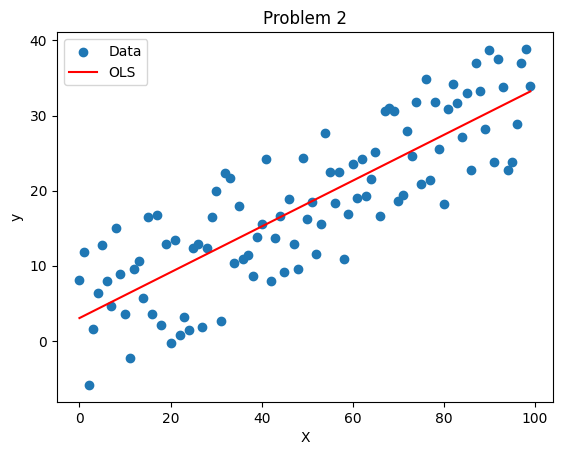

In [34]:
n = 100 # Number of points to generate
X = np.arange(n) # The input X for the function ols
eps = np.random.uniform(-10,10, size=(n,)) # Noise to generate random y-coordinates
y = .3*X + 3 + eps # The input y for the function ols

# compute beta
beta = ols(X, y)

# show data and OLS fit
plt.scatter(X, y, label='Data')
plt.plot(X, beta[0] + beta[1]*X, color='red', label='OLS')
plt.xlabel('X')
plt.ylabel('y')
plt.title("Problem 2")
plt.legend()
plt.show()

## Problem 3
Write a function that finds the least squares estimator for rank-deficient models using the SVD. 
The function should still take $X$ and **y** as inputs. Call the function **svd_ols** and return the least squares estimator for $\beta$ as a numpy array.

In [5]:
def svd_ols(X, y, r=None):
    """
    Solves for the least squares estimator using the SVD.
    Add a column of 1s to X.
    Parameters:
        X: n x d numpyarray
        y: n x 1 numpyarray
    Returns:
        beta: d x 1 numpy array
    """
    # Add a column of 1s to X
    if len(X.shape) == 1:
        X = X[:, np.newaxis]
    X = np.hstack((np.ones((X.shape[0], 1)), X))

    # compute svd
    U, S, Vt = np.linalg.svd(X, full_matrices=False)

    # compute beta and return
    return Vt[:r, :].T @ np.diag(1/S[:r])@ U[:, :r].T @ y

## Problem 4
Use your function **svd_ols** to find the least squares estimator for a cubic polynomial. 
Create a plot that shows a scatter plot of the data and a curve using the least squares estimator. 
Your plot should include a title, axis labels, and a legend.

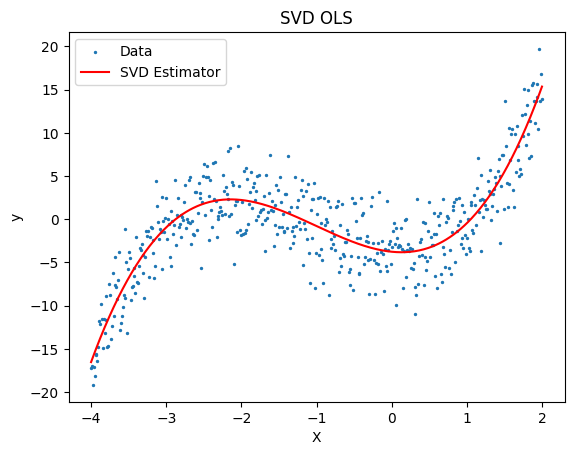

In [36]:
x = np.linspace(-4, 2, 500)
y = x**3 + 3*x**2 - x - 3.5
eps = np.random.normal(0, 3, len(y)) # Create noise
y += eps # Add noise to randomize data

# construct X in polynomial form
X = x[:, np.newaxis]
X = np.hstack((X, [xi**2 for xi in X], [xi**3 for xi in X]))

# compute beta
beta = svd_ols(X, y)

# plot data and fit
plt.scatter(x, y, label='Data', s=2)
plt.plot(x, beta[0] + beta[1]*x + beta[2]*x**2 + beta[3]*x**3, color='red', label='SVD Estimator')
plt.xlabel('X')
plt.ylabel('y')
plt.title("SVD OLS")
plt.legend()
plt.show()

## Problem 5
The file **realestate.csv** contains transaction data from 2012-2013. 
It has columns for transaction data, house age, distance to nearest MRT station, number of convenience stores, latitude, longitude, and house price of unit area.
Each row in the array is a separate measurement.

Find the combination of variables that builds the model with the best $R^2$ value when predicting **house price of unit area**. Use statsmodels to build each model and calculate $R^2$. Use **statsmodels** to build each model and calculate $R^2$. Using the same combination of variables, time the methods **ols**, **svd_ols**, and **statsmodels** . Return a list with the first element being a tuple of times for each method and the second element being the best $R^2$ value from the first part of the problem.

In [6]:
def problem5():
    """
    Find the best R2 value using statsmodels.
    Then time ols, svd_ols, and statsmodlels.
    Returns:
        list(): a tuple of times and the best R2 value
    """
    path = '/mnt/c/users/dalli/source/acme_senior/vl3labs/LinearRegression/realestate.csv'
    real_estate = pd.read_csv(path)

    # get all combinations of features
    features = list(real_estate.columns)
    features.remove('Y house price of unit area')
    features.remove('No')
    
    # use combinations to get all combinations of features
    feature_combos = []
    for r in range(1, len(features) + 1):
        feature_combos.extend(combinations(features, r))
    y = real_estate["Y house price of unit area"]

    best_feat = None
    best_rs = 0
    for feat in feature_combos:
        # set up model and find best fit
        # print(feat)
        # print(real_estate.columns)
        # print(real_estate[list(feat)].columns)
        # print()
        temp_X = real_estate[list(feat)]
        X = sm.add_constant(temp_X)
        model = sm.OLS(y, X).fit()

        # update
        if model.rsquared > best_rs or best_rs == 0:
            best_rs = model.rsquared
            best_feat = feat
    
    temp_X = real_estate[list(best_feat)]
    best_X = sm.add_constant(temp_X)

    # time statsmodels with the best features
    start3 = time.perf_counter()
    sm.OLS(y, best_X).fit()
    sm_time = time.perf_counter() - start3

    # convert best_X to numpy array
    best_X = temp_X.to_numpy()

    # time ols with the best features
    start = time.perf_counter()
    ols(best_X, y)
    ols_time = time.perf_counter() - start

    # time svd_ols with the best features
    start2 = time.perf_counter()
    svd_ols(best_X, y)
    svd_time = time.perf_counter() - start2

    return [ols_time, svd_time, sm_time], best_rs


print(problem5())


([0.0005389000000377564, 0.0013586999999688487, 0.0017340000000558575], 0.5823704472723095)


## Problem 6
Use the file **realestate.csv** and the Python Example on page 4 as a template for constructing **y** and $X$ and calculating model AIC and BIC. 
For the dependent variable, use **house price of unit area**. 
For the independent variables, use **distance to the nearest MRT station**, **number of convenience stores**, **latitude**, and **longitude**.

Find the model that has the lowest AIC and the model that has the lowest BIC. Are they the same model? Print the features of the model with the lowest AIC as a list.

In [61]:
path = '/mnt/c/users/dalli/source/acme_senior/vl3labs/LinearRegression/realestate.csv'
real_estate = pd.read_csv(path)

# get all combinations of features
features = list(real_estate.columns)
features.remove('Y house price of unit area')
features.remove('No')

# use combinations to get all combinations of features of all lengths
feature_combos = []
for r in range(1, len(features) + 1):
    feature_combos.extend(combinations(features, r))
    
y = real_estate["Y house price of unit area"]

# initialize loop variables
best_afeat = None
best_bfeat = None
aics = []
bics = []
best_aic = 0
best_bic = 0

for feat in feature_combos:
    # set up model and find best fit
    temp_X = real_estate[list(feat)]
    X = sm.add_constant(temp_X)
    model = sm.OLS(y, X).fit()

    # save aic and bic
    aic_curr = model.aic
    bic_curr = model.bic
    aics.append(aic_curr)
    bics.append(bic_curr)

    # update
    if aic_curr < best_aic or best_aic == 0:
        best_aic = aic_curr
        best_afeat = feat
    if bic_curr < best_bic or best_bic == 0:
        best_bic = bic_curr
        best_bfeat = feat

print("The model that has the lowest AIC and the model that has the lowest BIC are the same:", best_afeat == best_bfeat)
print(best_afeat)

The model that has the lowest AIC and the model that has the lowest BIC are the same:  True
('X1 transaction date', 'X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X5 latitude')


## Problem 7
Use Ridge and Lasso Regression to model **house price of unit area** from the file **realestate.csv**.
Before fitting each model, run a GridSearch on $\alpha$ to find the optimal value.
Then use the optimal $\alpha$ to fit the model.
Once you have fit the model, you can use the **score** method to get $R^2$. 
Print $R^2$ for each model as a tuple. 

In [69]:
path = '/mnt/c/users/dalli/source/acme_senior/vl3labs/LinearRegression/realestate.csv'
real_estate = pd.read_csv(path)

# get all combinations of features
features = list(real_estate.columns)
features.remove('Y house price of unit area')
features.remove('No')
temp_X = real_estate[features]
    
X = sm.add_constant(temp_X)
y = real_estate["Y house price of unit area"]

ridge = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13))
ridge.fit(X, y) 
print("Ridge:")
print("Best alpha:", ridge.alpha_)
print("Best score:", ridge.score(X, y))

lasso = linear_model.LassoCV(alphas=np.logspace(-6, 6, 13))
lasso.fit(X, y) 
print("\nLasso:")
print("Best alpha:", lasso.alpha_)
print("Best score:", lasso.score(X, y))

Ridge:
Best alpha: 0.001
Best score: 0.5823546181203794

Lasso:
Best alpha: 0.001
Best score: 0.5822617746793004
